In [7]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [9]:

CSV_PATH = Path("../data/FAOSTAT_data_en_10-14-2025.csv").resolve()


df_raw = pd.read_csv(CSV_PATH, dtype=str)
print("rows:", len(df_raw), "Columns:", list(df_raw.columns))

def load_fao_country(df, country_name, item_keyword="Food Indices"):
    dfc = df.copy()
    mask = (dfc['Area'] == country_name) & dfc['Item'].str.contains(item_keyword, na=False)
    dfc = dfc.loc[mask].copy()

    # fix data types of each thing
    dfc['Value'] = pd.to_numeric(dfc['Value'], errors='coerce')
    dfc['Year'] = dfc['Year'].astype(str)
    dfc['date'] = pd.to_datetime(dfc['Year'] + ' ' + dfc['Months'], format="%Y %B", errors='coerce')

    #drop any rows missing a date or value and then sort by date
    dfc = dfc.dropna(subset=['date','Value']).copy()
    dfc = dfc.sort_values('date').reset_index(drop=True)
    return dfc

# print num rows for each country we care abt
for c in ["Canada", "United States of America", "Mexico"]:
    print(c, "rows:", len(load_fao_country(df_raw, c)))

rows: 909 Columns: ['Area', 'Year', 'Item', 'Months', 'Value', 'date']
Canada rows: 303
United States of America rows: 303
Mexico rows: 303


In [ ]:
def prepare_prophet_df(df_country):
    # returns a ds and y df for prophet for each country
    dfp = df_country.loc[:, ['date','Value']].rename(columns={'date':'ds','Value':'y'}).copy()
    dfp['ds'] = pd.to_datetime(dfp['ds'])
    # sort by date and reset index
    dfp = dfp.sort_values('ds').reset_index(drop=True)
    return dfp

from sklearn.metrics import mean_absolute_error

def prophet_rolling_backtest(df_prophet, horizon=12, initial_train_months=60, period=12, verbose=True):
    # each model uses the past initial_train_months to predict the next horizon months
    # then rolls forward by period months and repeats until the end of the data
    # returns a DataFrame with columns: train_end, test_start, test_end, mae
    n = len(df_prophet)
    results = []

    for start_train_end in range(initial_train_months, n - horizon + 1, period):
        train = df_prophet.iloc[:start_train_end].copy()
        test = df_prophet.iloc[start_train_end:start_train_end + horizon].copy()
        m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
        m.fit(train)
        future = m.make_future_dataframe(periods=horizon, freq='MS')  # month start
        fc = m.predict(future)
        # predictions corresponding to test ds:
        pred = fc.set_index('ds').loc[test['ds'], 'yhat'].values
        y_true = test['y'].values
        mae = mean_absolute_error(y_true, pred)
        mape = np.mean(np.abs((y_true - pred) / y_true)) * 100
        results.append({
            'train_end': train['ds'].iloc[-1],
            'test_start': test['ds'].iloc[0],
            'test_end': test['ds'].iloc[-1],
            'mae': mae,
            'mape': mape
        })
        if verbose:
            print(f"Fold train_end={train['ds'].iloc[-1].date()}, mae={mae:.3f}, mape={mape:.2f}%")
    res_df = pd.DataFrame(results)
    if verbose:
        print("\nBacktest summary — MAE mean:", res_df['mae'].mean(), "MAPE mean:", res_df['mape'].mean())
    return res_df

15:57:30 - cmdstanpy - INFO - Chain [1] start processing
15:57:30 - cmdstanpy - INFO - Chain [1] done processing


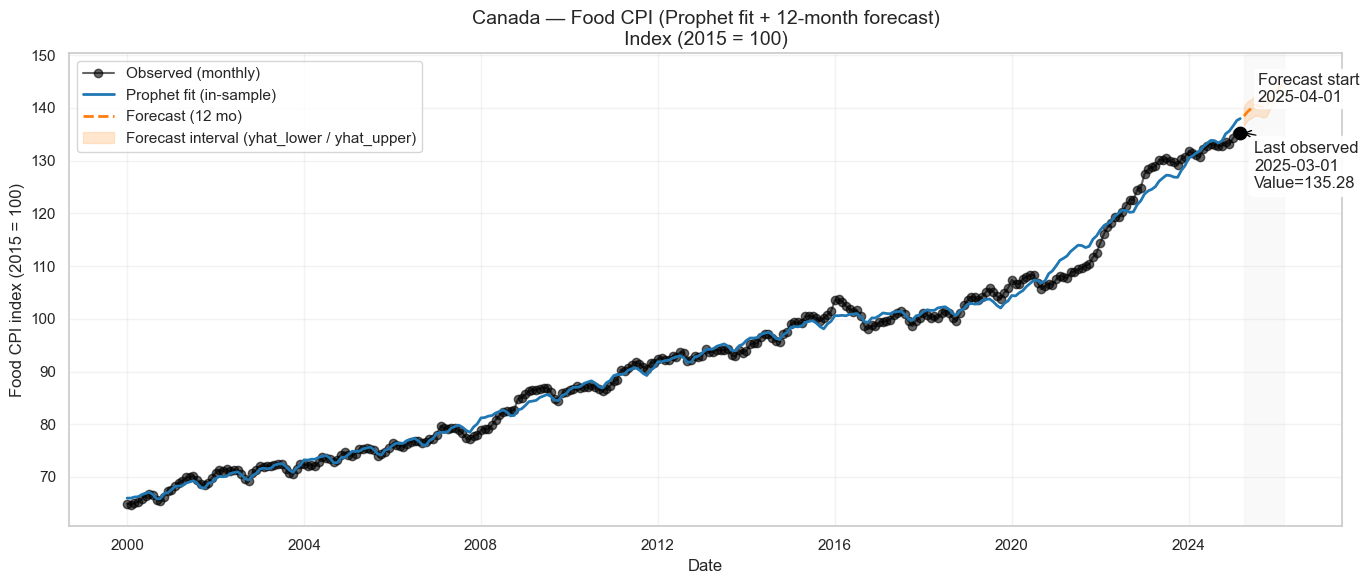

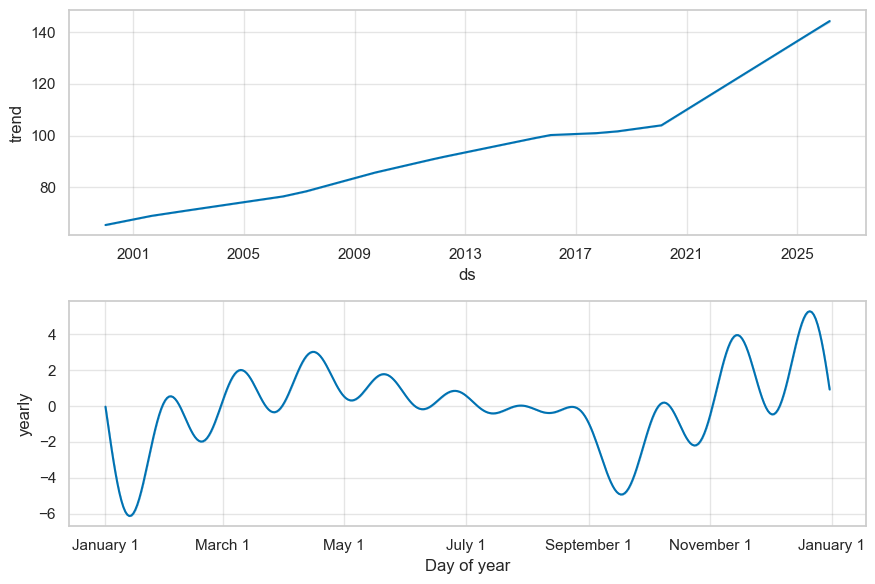

In [12]:
# fits prophet model
# produces plots with history, fit, forecast, intervals
# runs rolling-origin backtest optionally
country = "Canada"
dfc = load_fao_country(df_raw, country)
dfp = prepare_prophet_df(dfc)

# Fit on full data and create a 12-month forecast
m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(dfp)
future = m.make_future_dataframe(periods=12, freq='MS')   # monthly forecast points
forecast = m.predict(future)

# Prepare data for plotting
last_obs = dfp['ds'].max()
history = dfp.copy()
fc_all = forecast.copy()
fc_future = fc_all[fc_all['ds'] > last_obs].reset_index(drop=True)

# Plot: history, fitted, forecast, and intervals
plt.figure(figsize=(14,6))
ax = plt.gca()

# Historical observations
ax.plot(history['ds'], history['y'], marker='o', linestyle='-', color='black', alpha=0.6, label='Observed (monthly)')

# In-sample fitted values 
in_sample = fc_all[fc_all['ds'] <= last_obs]
ax.plot(in_sample['ds'], in_sample['yhat'], color='#1f77b4', linewidth=2, label='Prophet fit (in-sample)')

# Forecasted values 
ax.plot(fc_future['ds'], fc_future['yhat'], color='#ff7f0e', linewidth=2, linestyle='--', label='Forecast (12 mo)')

# Forecast uncertainty band 
ax.fill_between(fc_future['ds'],
                fc_future['yhat_lower'],
                fc_future['yhat_upper'],
                color='#ffbb78', alpha=0.35, label='Forecast interval (yhat_lower / yhat_upper)')

# Highlight forecast period
ax.axvspan(fc_future['ds'].min(), fc_future['ds'].max(), color='lightgrey', alpha=0.12)

# Annotate last observed value
last_y = history.loc[history['ds'] == last_obs, 'y'].iloc[0]
ax.scatter([last_obs], [last_y], color='black', s=80)
ax.annotate(f"Last observed\n{last_obs.date()}\nValue={last_y:.2f}",
            xy=(last_obs, last_y),
            xytext=(10, -40),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color='black'))

# Annotate first forecast point
first_fc = fc_future.iloc[0]
ax.annotate(f"Forecast start\n{first_fc['ds'].date()}",
            xy=(first_fc['ds'], first_fc['yhat']),
            xytext=(10, 10),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.9))

# Labels, title, legend
ax.set_title(f"{country} — Food CPI (Prophet fit + 12-month forecast)\nIndex (2015 = 100)", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Food CPI index (2015 = 100)")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Show component plots (trend + yearly seasonality)
fig2 = m.plot_components(forecast)
plt.show()


15:57:45 - cmdstanpy - INFO - Chain [1] start processing
15:57:45 - cmdstanpy - INFO - Chain [1] done processing
15:57:46 - cmdstanpy - INFO - Chain [1] start processing
15:57:46 - cmdstanpy - INFO - Chain [1] done processing
15:57:46 - cmdstanpy - INFO - Chain [1] start processing
15:57:46 - cmdstanpy - INFO - Chain [1] done processing


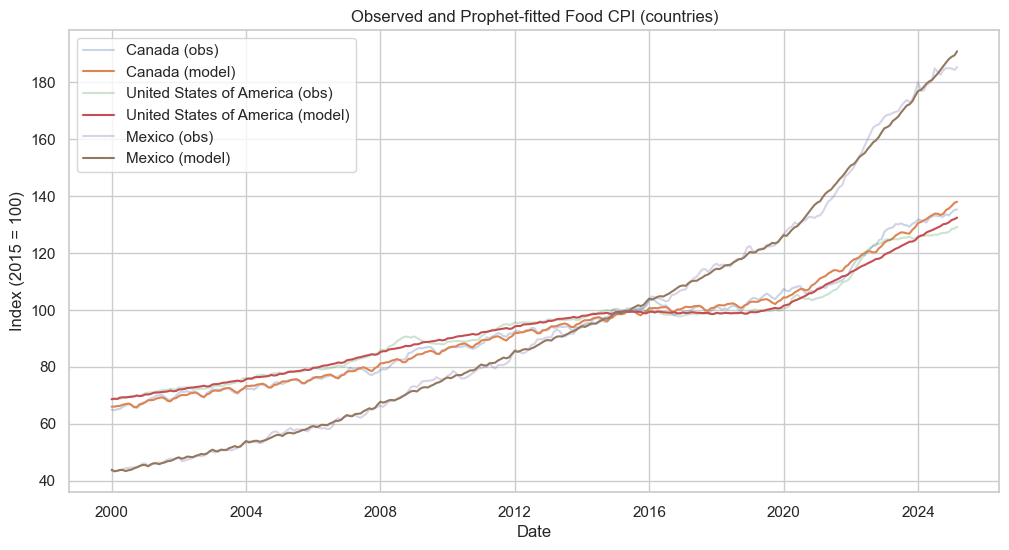

In [13]:
# run for every country and plot all together
countries = ["Canada", "United States of America", "Mexico"]
plt.figure(figsize=(12,6))
for country in countries:
    dfc = load_fao_country(df_raw, country)
    dfp = prepare_prophet_df(dfc)
    # fit light Prophet and predict only a small horizon for plotting
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.fit(dfp)
    # produce in-sample prediction for plotting smooth line
    in_sample = m.predict(dfp.rename(columns={'ds':'ds'}))
    plt.plot(dfp['ds'], dfp['y'], alpha=0.3, label=f"{country} (obs)")
    plt.plot(in_sample['ds'], in_sample['yhat'], label=f"{country} (model)")
plt.title("Observed and Prophet-fitted Food CPI (countries)")
plt.xlabel("Date")
plt.ylabel("Index (2015 = 100)")
plt.legend()
plt.show()